In [2]:
from abc import ABC, abstractmethod
from typing import Optional, Tuple, Any
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles # 假设这些导入是可用的

In [ ]:
# --- Helper Function to Render Points to Image ---
def _render_points_to_image(points: torch.Tensor, image_size: int, scale: float, device: torch.device) -> torch.Tensor:
    """
    Renders 2D points onto a square grayscale image.
    Points are assumed to be in a range relative to the scale, e.g., [-scale, scale].
    The output image will have values between 0 (empty) and 1 (point present).

    Args:
        points: A tensor of 2D points with shape (N, 2).
        image_size: The desired height and width of the square image (e.g., 64).
        scale: The maximum absolute coordinate value from the data source (e.g., 5.0).
               Used to normalize points into the [0, 1] image coordinate system.
        device: The device (cpu or cuda) for the output tensor.

    Returns:
        A flattened tensor representing a single grayscale image of shape (image_size * image_size,).
    """
    img = torch.zeros((image_size, image_size), device=device, dtype=torch.float32)

    # Normalize points to [0, 1] range for image coordinates
    # Original points are assumed to be in [-scale, scale] range.
    normalized_points = (points + scale) / (2 * scale)

    # Convert to pixel coordinates
    # Clamp to ensure points are within image bounds [0, image_size - 1]
    pixel_x = torch.clamp((normalized_points[:, 0] * image_size).long(), 0, image_size - 1)
    pixel_y = torch.clamp((normalized_points[:, 1] * image_size).long(), 0, image_size - 1)

    # Set pixels where points exist to 1.0
    # Using advanced indexing to efficiently set pixels
    img[pixel_y, pixel_x] = 1.0 # Note: (y, x) for image indexing

    # --- MODIFIED: Flatten the image before returning ---
    return img.view(image_size * image_size) # Return flattened shape (H*W,)


# --- Abstract Class Sampleable Definition ---
class Sampleable(ABC):
    # The class that can be sampled from

    @abstractmethod
    def sample(self) -> torch.Tensor:
        # Return a single image sample of flattened shape (channels * height * width,)
        pass

    @abstractmethod
    def batch_samples(self, num_samples: int) -> torch.Tensor:
        # Return a batch of samples where batch_size = num_samples.
        # Shape: (batch_size, channels * height * width)
        pass

    @property
    @abstractmethod
    def dim(self) -> int:
        # Return the flattened dimension of a single sample (e.g., 1 * 64 * 64 = 4096)
        pass

    @property
    @abstractmethod
    def image_shape(self) -> Tuple[int, int, int]:
        # Return the original image shape (channels, height, width) for conceptual understanding/reshaping
        pass

In [ ]:
class GaussianSampleable(Sampleable):
    """
    Implementation of a 2D Gaussian distribution, rendered as an image.
    """
    def __init__(self, device: torch.device, image_size: int = 64, mean: Optional[torch.Tensor] = None,
                 covariance: Optional[torch.Tensor] = None, scale: float = 5.0, points_per_image: int = 50000):
        """
        Args:
            device: The device (cpu or cuda) to place the generated tensors.
            image_size: The desired height and width of the square image.
            mean: Mean of the 2D Gaussian distribution. Defaults to [0.0, 0.0].
            covariance: Covariance matrix of the 2D Gaussian distribution. Defaults to identity matrix.
            scale: How much to scale the data points before rendering. Used for mapping to image space.
            points_per_image: The number of underlying 2D points to generate for rendering each image.
        """
        self.device = device
        self.image_size = image_size
        self.scale = scale
        self.points_per_image = points_per_image

        if mean is None:
            self.mean = torch.tensor([0.0, 0.0], device=device, dtype=torch.float32)
        else:
            self.mean = mean.to(device)

        if covariance is None:
            self.covariance = torch.eye(2, device=device, dtype=torch.float32)
        else:
            self.covariance = covariance.to(device)

        # Create a multivariate normal distribution
        self.mvn = torch.distributions.MultivariateNormal(self.mean, self.covariance)

    @property
    def dim(self) -> int:
        return 1 * self.image_size * self.image_size

    @property
    def image_shape(self) -> Tuple[int, int, int]:
        return (1, self.image_size, self.image_size)

    def sample(self) -> torch.Tensor:
        """
        Generates a single Gaussian image sample of flattened shape (image_size * image_size,).
        """
        points = self.mvn.sample((self.points_per_image,))
        # _render_points_to_image now returns flattened tensor directly
        return _render_points_to_image(points, self.image_size, self.scale, self.device)

    def batch_samples(self, num_samples: int) -> torch.Tensor:
        """
        Generates a batch of Gaussian image samples with shape (num_samples, image_size * image_size).
        """
        batch_images = []
        for _ in range(num_samples):
            single_image = self.sample() # single_image is now (dim,)
            batch_images.append(single_image)
        # torch.stack will stack (dim,) tensors to (num_samples, dim)
        return torch.stack(batch_images, dim=0)

In [ ]:
class MoonsSampleable(Sampleable):
    """
    Implementation of the Moons distribution, rendered as an image.
    """
    def __init__(self, device: torch.device, image_size: int = 64, noise: float = 0.05, scale: float = 5.0,
                 offset: Optional[torch.Tensor] = None, points_per_image: int = 50000):
        """
        Args:
            device: The device (cpu or cuda) to place the generated tensors.
            image_size: The desired height and width of the square image.
            noise: Standard deviation of Gaussian noise added to the data points.
            scale: How much to scale the data points before rendering.
            offset: How much to shift the data points from the original distribution (2,).
            points_per_image: The number of underlying 2D points to generate for rendering each image.
                                More points lead to denser and more well-defined shapes.
        """
        self.device = device
        self.image_size = image_size
        self.noise = noise
        self.scale = scale
        self.points_per_image = points_per_image # Internal parameter for rendering density
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 1 * self.image_size * self.image_size # Channels * Height * Width

    @property
    def image_shape(self) -> Tuple[int, int, int]:
        return (1, self.image_size, self.image_size) # 1 channel for grayscale

    def sample(self) -> torch.Tensor:
        """
        Generates a single moon image sample of flattened shape (image_size * image_size,).
        """
        points, _ = make_moons(
            n_samples=self.points_per_image,
            noise=self.noise,
            random_state=None
        )
        points_tensor = self.scale * torch.from_numpy(points.astype(np.float32)).to(self.device) + self.offset
        # _render_points_to_image now returns flattened tensor directly
        return _render_points_to_image(points_tensor, self.image_size, self.scale, self.device)

    def batch_samples(self, num_samples: int) -> torch.Tensor:
        """
        Generates a batch of moon image samples with shape (num_samples, image_size * image_size).
        """
        batch_images = []
        for _ in range(num_samples):
            single_image = self.sample() # single_image is now (dim,)
            batch_images.append(single_image)
        # torch.stack will stack (dim,) tensors to (num_samples, dim)
        return torch.stack(batch_images, dim=0)

In [6]:
class CheckerboardSampleable(Sampleable):
    """
    Checkerboard-esque distribution, rendered as an image.
    """
    def __init__(self, device: torch.device, image_size: int = 64, grid_size: int = 3, scale: float = 5.0,
                 points_per_image: int = 50000):
        self.device = device
        self.image_size = image_size
        self.grid_size = grid_size
        self.scale = scale
        self.points_per_image = points_per_image

    @property
    def dim(self) -> int:
        return 1 * self.image_size * self.image_size

    @property
    def image_shape(self) -> Tuple[int, int, int]:
        return (1, self.image_size, self.image_size)

    def _generate_points_internal(self, num_points: int) -> torch.Tensor:
        """Helper to generate raw checkerboard points before trimming."""
        grid_length = 2 * self.scale / self.grid_size
        samples = torch.zeros(0, 2).to(self.device)
        while samples.shape[0] < num_points:
            new_samples = (torch.rand(num_points, 2).to(self.device) - 0.5) * 2 * self.scale
            # Apply checkerboard logic based on coordinates
            x_idx = torch.floor((new_samples[:,0] + self.scale) / grid_length).long()
            y_idx = torch.floor((new_samples[:,1] + self.scale) / grid_length).long()

            # A checkerboard cell is 'active' if sum of indices is even
            accept_mask = (x_idx + y_idx) % 2 == 0
            samples = torch.cat([samples, new_samples[accept_mask]], dim=0)
        return samples[:num_points]

    def sample(self) -> torch.Tensor:
        """
        Generates a single checkerboard image sample of flattened shape (image_size * image_size,).
        """
        points = self._generate_points_internal(self.points_per_image)
        # _render_points_to_image now returns flattened tensor directly
        return _render_points_to_image(points, self.image_size, self.scale, self.device)

    def batch_samples(self, num_samples: int) -> torch.Tensor:
        """
        Generates a batch of checkerboard image samples with shape (num_samples, image_size * image_size).
        """
        batch_images = []
        for _ in range(num_samples):
            single_image = self.sample() # single_image is now (dim,)
            batch_images.append(single_image)
        # torch.stack will stack (dim,) tensors to (num_samples, dim)
        return torch.stack(batch_images, dim=0)


In [ ]:
class CirclesSampleable(Sampleable):
    """
    Implementation of concentric circle distribution, rendered as an image.
    """
    def __init__(self, device: torch.device, image_size: int = 64, noise: float = 0.05, scale: float = 5.0,
                 offset: Optional[torch.Tensor] = None, points_per_image: int = 50000):
        self.device = device
        self.image_size = image_size
        self.noise = noise
        self.scale = scale
        self.points_per_image = points_per_image
        if offset is None:
            offset = torch.zeros(2)
        self.offset = offset.to(device)

    @property
    def dim(self) -> int:
        return 1 * self.image_size * self.image_size

    @property
    def image_shape(self) -> Tuple[int, int, int]:
        return (1, self.image_size, self.image_size)

    def sample(self) -> torch.Tensor:
        """
        Generates a single circle image sample of flattened shape (image_size * image_size,).
        """
        samples, _ = make_circles(
            n_samples=self.points_per_image,
            noise=self.noise,
            factor=0.5,
            random_state=None
        )
        points_tensor = self.scale * torch.from_numpy(samples.astype(np.float32)).to(self.device) + self.offset
        # _render_points_to_image now returns flattened tensor directly
        return _render_points_to_image(points_tensor, self.image_size, self.scale, self.device)

    def batch_samples(self, num_samples: int) -> torch.Tensor:
        """
        Generates a batch of circle image samples with shape (num_samples, image_size * image_size).
        """
        batch_images = []
        for _ in range(num_samples):
            single_image = self.sample() # single_image is now (dim,)
            batch_images.append(single_image)
        # torch.stack will stack (dim,) tensors to (num_samples, dim)
        return torch.stack(batch_images, dim=0)


Starting visualization on device: cuda

Generating 8 image samples for Default Gaussian Images...
Generated batch shape: torch.Size([8, 4096])


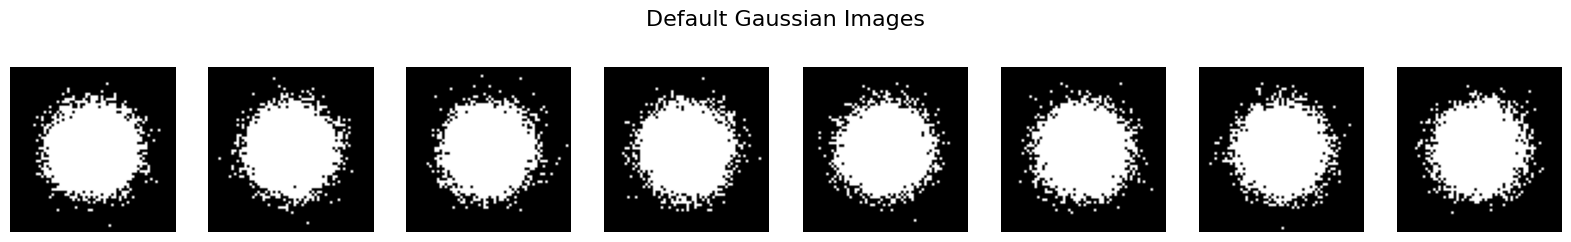

Default Gaussian Images dim: 4096, image_shape: (1, 64, 64)

Generating 8 image samples for Stretched Gaussian Images...
Generated batch shape: torch.Size([8, 4096])


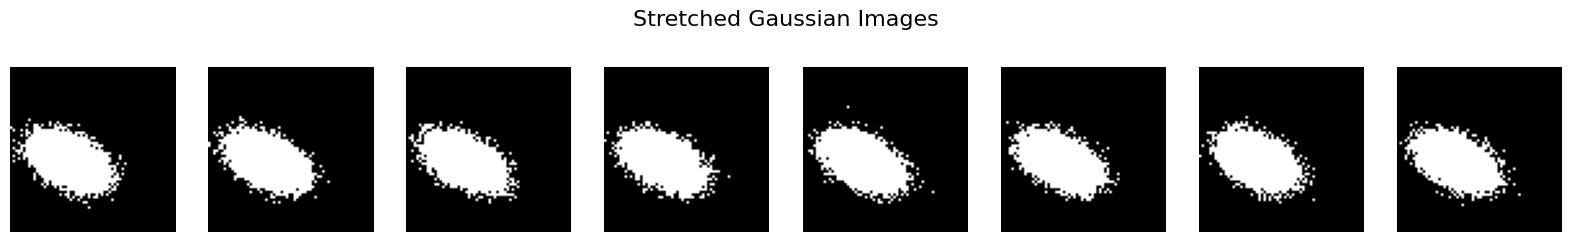

Stretched Gaussian Images dim: 4096, image_shape: (1, 64, 64)

Generating 8 image samples for Moons Images...
Generated batch shape: torch.Size([8, 4096])


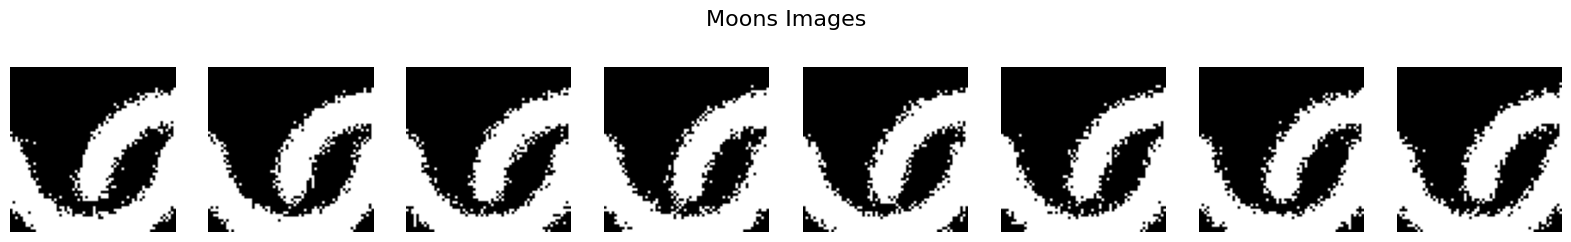

Moons Images dim: 4096, image_shape: (1, 64, 64)

Generating 8 image samples for Circles Images...
Generated batch shape: torch.Size([8, 4096])


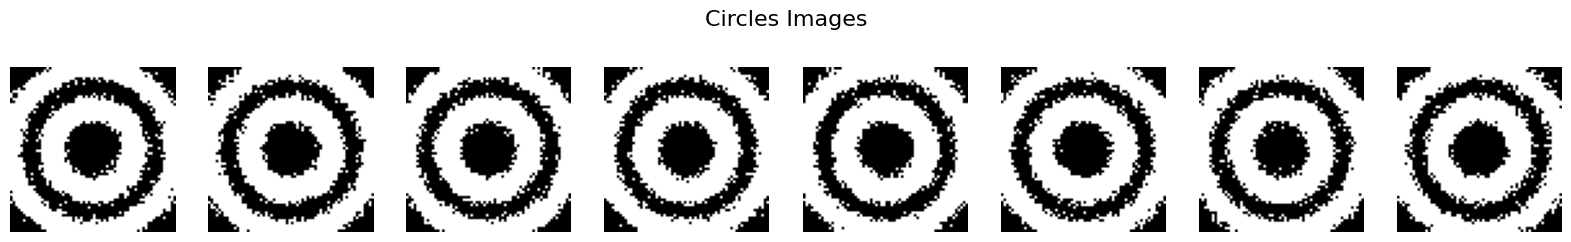

Circles Images dim: 4096, image_shape: (1, 64, 64)

Generating 8 image samples for Checkerboard Images...
Generated batch shape: torch.Size([8, 4096])


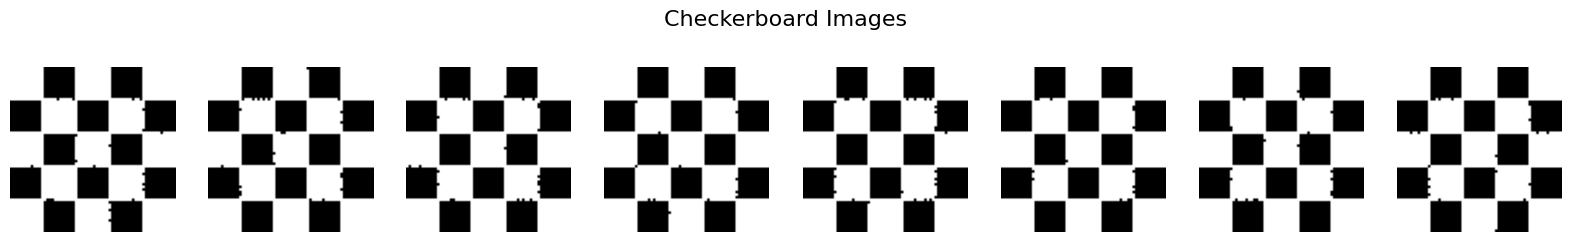

Checkerboard Images dim: 4096, image_shape: (1, 64, 64)

Testing single sample generation (shape and value check):
Single moon image shape: torch.Size([4096]), first few values:
tensor([0., 0., 0., 0.], device='cuda:0')
Single Gaussian image shape: torch.Size([4096]), first few values:
tensor([0., 0., 0., 0.], device='cuda:0')


In [ ]:
def visualize_all_samples(
    image_resolution: int = 64,
    points_density: int = 20000,
    num_images_to_show: int = 8,
    device: torch.device = torch.device("cpu")
):
    """
    Initializes and visualizes samples from all Sampleable distributions.

    Args:
        image_resolution: The desired height and width of the square image.
        points_density: The number of underlying 2D points to generate for rendering each image.
        num_images_to_show: The number of images to display from each distribution's batch.
        device: The device (cpu or cuda) to place the generated tensors.
    """
    print(f"Starting visualization on device: {device}\n")

    # Re-define the internal visualization helper to be here, for clarity in this cell
    def _plot_images(sampleable_instance: Sampleable, num_images: int, title: str):
        print(f"Generating {num_images} image samples for {title}...")
        batch_images = sampleable_instance.batch_samples(num_images)
        print(f"Generated batch shape: {batch_images.shape}") # Now will print (num_images, dim)

        display_images = batch_images.cpu()

        plt.figure(figsize=(num_images * 2, 2.5))
        plt.suptitle(title, fontsize=16)

        # Get H and W from image_shape for reshaping
        _, H, W = sampleable_instance.image_shape 

        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            # --- MODIFIED: Reshape flattened image back to (H, W) for imshow ---
            img = display_images[i].reshape(H, W) 
            ax.imshow(img.numpy(), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        print(f"{title} dim: {sampleable_instance.dim}, image_shape: {sampleable_instance.image_shape}\n")


    # --- Initialize and Visualize each Sampleable Type ---

    # 1. Gaussian Images
    # Default Gaussian (mean=[0,0], cov=I)
    gaussian_sampler_default = GaussianSampleable(device=device, image_size=image_resolution,
                                                  points_per_image=points_density)
    _plot_images(gaussian_sampler_default, num_images_to_show, "Default Gaussian Images")

    # Stretched Gaussian (example with custom mean/covariance)
    stretched_mean = torch.tensor([-2.0, 1.0])
    stretched_covariance = torch.tensor([[1.5, 0.5], [0.5, 0.8]])
    gaussian_sampler_stretched = GaussianSampleable(device=device, image_size=image_resolution,
                                                    mean=stretched_mean, covariance=stretched_covariance,
                                                    scale=7.0, points_per_image=points_density)
    _plot_images(gaussian_sampler_stretched, num_images_to_show, "Stretched Gaussian Images")


    # 2. Moons Images
    moons_sampler = MoonsSampleable(device=device, image_size=image_resolution, noise=0.08,
                                    scale=6.0, points_per_image=points_density)
    _plot_images(moons_sampler, num_images_to_show, "Moons Images")

    # 3. Circles Images
    circles_sampler = CirclesSampleable(device=device, image_size=image_resolution, noise=0.06,
                                        scale=7.0, points_per_image=points_density)
    _plot_images(circles_sampler, num_images_to_show, "Circles Images")

    # 4. Checkerboard Images
    checkerboard_sampler = CheckerboardSampleable(device=device, image_size=image_resolution,
                                                  grid_size=5, scale=6.0, points_per_image=points_density)
    _plot_images(checkerboard_sampler, num_images_to_show, "Checkerboard Images")

    # --- Test single sample generation ---
    print("Testing single sample generation (shape and value check):")
    moon_single_image = moons_sampler.sample()
    print(f"Single moon image shape: {moon_single_image.shape}, first few values:\n{moon_single_image[:4]}") # Display first few flattened values

    gaussian_single_image = gaussian_sampler_default.sample()
    print(f"Single Gaussian image shape: {gaussian_single_image.shape}, first few values:\n{gaussian_single_image[:4]}") # Display first few flattened values

# --- Execute visualization ---
# Choose device (GPU if available, otherwise CPU)
chosen_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Call the unified visualization function
visualize_all_samples(device=chosen_device)